In [1]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
# sys.path.insert(1, '/home/chaklam/bci_project/BCI/P300/utils')

import pandas as pd
import numpy as np
import pickle

import mne
from mne.time_frequency import psd_welch

# import helper as helper #custom

# visualization stuff
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

In [2]:
X = np.load('../th_data/X_cb_sit.npy')
y = np.load('../th_data/y_cb_sit.npy')

/home/chanapa/bci_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/chanapa/bci_env/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Saved ERP + TS Model !
              precision    recall  f1-score   support

  Non-target       0.95      0.99      0.97      3960
     targets       0.71      0.39      0.50       360

    accuracy                           0.94      4320
   macro avg       0.83      0.69      0.73      4320
weighted avg       0.93      0.94      0.93      4320

Saved ERP + MDM Model !
              precision    recall  f1-score   support

  Non-target       0.98      0.80      0.88      3960
     targets       0.27      0.78      0.40       360

    accuracy                           0.80      4320
   macro avg       0.62      0.79      0.64      4320
weighted avg       0.92      0.80      0.84      4320

Saved Xdawn + RegLDA Model !
              precision    recall  f1-score   support

  Non-target       0.95      0.98      0.96      3960
     targets       0.64      0.47      0.54       360

    accuracy                           0.93      4320
   macro avg       0.80      0.72      0.75      432

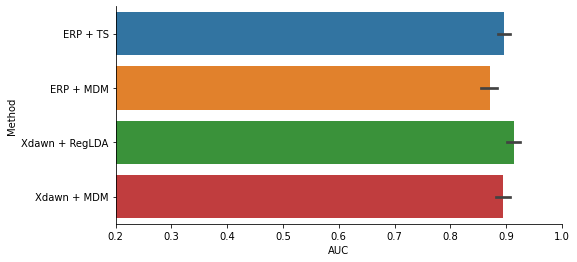

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from mne.preprocessing import Xdawn
from pyriemann.estimation import ERPCovariances
from collections import OrderedDict
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.estimation import XdawnCovariances

from sklearn.metrics import classification_report


from mne.decoding import Vectorizer
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline

lda = LDA(shrinkage='auto', solver='eigen') #Regularized LDA
lr = LogisticRegression(penalty='l1', solver='liblinear',
                                       multi_class='auto')

clfs = OrderedDict()

n_components = 3

clfs['ERP + TS']= make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['ERP + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clfs['Xdawn + RegLDA'] = make_pipeline(XdawnCovariances(n_components, 
                            estimator='oas'), Vectorizer(), lda)
clfs['Xdawn + MDM'] = make_pipeline(XdawnCovariances(n_components,
                            estimator='oas'), MDM())

# Cross validator
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

for clf in clfs:
    # Do cross-validation
    preds = np.empty(len(y))
    for train, test in cv.split(X, y):  #Xdawn takes in epoch object
        clfs[clf].fit(X[train], y[train])
        preds[test] = clfs[clf].predict(X[test])

    # Classification report
    target_names = ['Non-target', 'targets']
    report = classification_report(y, preds, target_names=target_names)
    
    # Save to file in the current working directory
    pkl_filename = f"sit_{clf}_cb_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(clfs[clf], file)
        
    print(f"Saved {clf} Model !")
    print(report)
    
# measure auc
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 1)
sns.despine()

In [4]:
# # Load from file
    # with open(pkl_filename, 'rb') as file:
    #     pickle_model = pickle.load(file)